### Importar Librerias

In [56]:
import pandas as pd
import csv
import matplotlib.pyplot as plt

import seaborn as sns


## Mercado eléctrico español

In [57]:
resu = pd.read_csv('data_generacion/resumen.csv', encoding='latin1').T


In [58]:
def limpiar_dataframe(df):
    # Copiar el DataFrame para evitar modificar el original
    df_limpiado = df.copy()

    # Establecer los nombres de columna a partir de la primera fila y eliminar esa fila
    df_limpiado.columns = df_limpiado.iloc[0]
    df_limpiado = df_limpiado.drop(df_limpiado.index[0])

    # Contar los valores nulos en cada columna
    num_nulls = df_limpiado.isnull().sum()

    # Obtener las columnas con más de 10 valores nulos
    columns_to_drop = num_nulls[num_nulls > 10].index

    # Eliminar las columnas del DataFrame
    df_limpiado = df_limpiado.drop(columns_to_drop, axis=1)

    # Quitarle el título a la columna
    df_limpiado.columns.name = None

    #Seleccionar las columnas deseadas
    columnas_deseadas = ['Hidráulica',
       'Turbinación bombeo', 'Nuclear', 'Carbón',
       'Motores diésel', 'Turbina de gas', 'Turbina de vapor',
       'Ciclo combinado', 'Hidroeólica', 'Eólica', 'Solar fotovoltaica',
       'Solar térmica', 'Otras renovables', 'Cogeneración',
       'Residuos no renovables', 'Residuos renovables', 'Generación total']
    df_limpiado = df_limpiado.loc[:, columnas_deseadas]

    #Lista de columnas a modificar
    #columnas = ['Hidráulica', 'Hidroeólica', 'Eólica', 'Solar fotovoltaica', 'Solar térmica', 'Otras renovables', 'Residuos renovables']

    # Reemplazar la coma por un punto y convertir a tipo float
    for columna in columnas_deseadas:
        df_limpiado[columna] = df_limpiado[columna].str.replace(',', '.').astype(float)

    # Resetear el índice
    df_limpiado = df_limpiado.reset_index(drop=True)

    return df_limpiado


In [59]:
resu = limpiar_dataframe(resu)

# añadir columna Year

resu['Year'] = ['2021', '2022', '2023']

resu = resu.drop('Generación total', axis=1)


In [60]:
resu

,Hidráulica,Turbinación bombeo,Nuclear,Carbón,Motores diésel,Turbina de gas,Turbina de vapor,Ciclo combinado,Hidroeólica,Eólica,Solar fotovoltaica,Solar térmica,Otras renovables,Cogeneración,Residuos no renovables,Residuos renovables,Year
0,11.394,1.019,20.784,1.917,0.968,0.163,0.426,17.115,0.009,23.278,8.069,1.810,1.815,10.034,0.861,0.338,2021
1,6.478,1.366,20.254,2.809,0.922,0.238,0.437,24.651,0.008,22.138,10.094,1.492,1.685,6.423,0.687,0.318,2022
2,10.031,2.162,20.524,1.450,0.836,0.253,0.456,14.633,0.007,25.832,13.025,1.633,1.394,7.036,0.447,0.281,2023


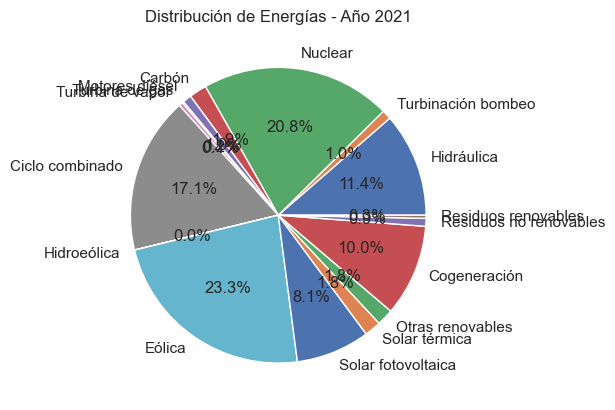

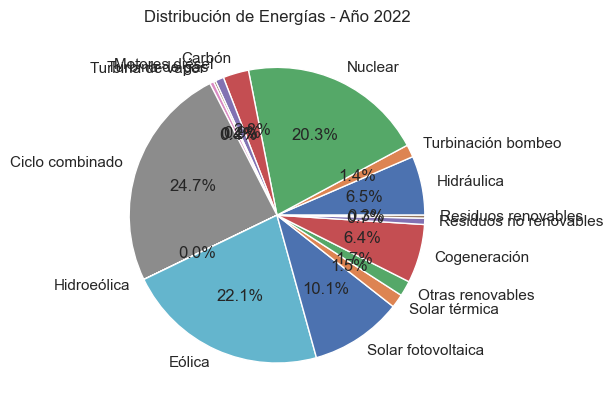

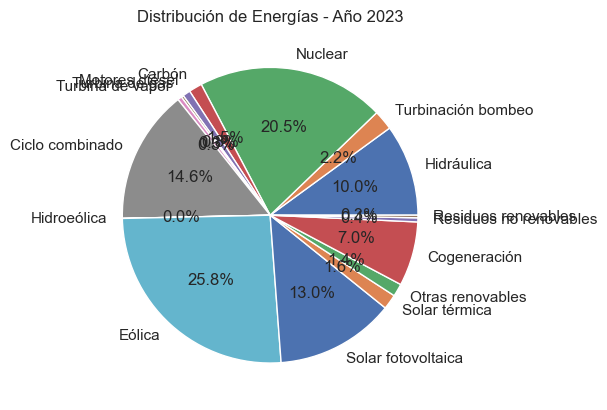

In [61]:
# Iterar sobre cada año y crear un pie chart para cada uno
for _, row in resu.iterrows():
    year = row['Year']
    energies = row.drop(['Year']).values
    labels = row.drop(['Year']).index

    plt.figure()
    plt.pie(energies, labels=labels, autopct='%1.1f%%')
    plt.title('Distribución de Energías - Año {}'.format(year))
    plt.show()


### Cargar el archivo 

Precio de la luz por días desde 1 Enero de 2014 hasta 27 de Mayo de 2023

- Value: €/Mwh
- URL: https://www.esios.ree.es/es/analisis/600?geoids=3&vis=1&start_date=01-01-2014T00%3A00&end_date=30-05-2023T23%3A55&compare_start_date=31-12-2013&groupby=day&zoom=5&latlng=36.13787471840729%2C-6.921386718749999

In [62]:
nombre_archivo = 'data_mw/days_2014-2023.csv'

data = []

with open(nombre_archivo, 'r') as archivo_csv:
    lector_csv = csv.reader(archivo_csv, delimiter=';')
    encabezado = next(lector_csv)
    
    for fila in lector_csv:
        data.append(fila)
        
df = pd.DataFrame(data, columns=encabezado)

df.columns


Index(['id', 'name', 'geoid', 'geoname', 'value', 'datetime'], dtype='object')

Eliminar columnas innecesarias

In [63]:
columnas_a_eliminar = ['name', 'geoid', 'geoname','id']
df = df.drop(columnas_a_eliminar, axis=1)

# Transformo la columna value a float

df['value'] = df['value'].astype(float)

# Convertir la columna 'datetime' al tipo de dato datetime
df['datetime'] = pd.to_datetime(df['datetime'], utc=True)
df['mes'] = df['datetime'].dt.month
df['dia'] = df['datetime'].dt.day
df['week'] = df['datetime'].dt.isocalendar().week
df['year'] = df['datetime'].dt.year
df['date'] = df['datetime'].dt.date
df['weekend'] = df['datetime'].dt.weekday ## la idea es transformarla para pillar findes



In [64]:
df.head()

,value,datetime,mes,dia,week,year,date,weekend
0,5.808750,2013-12-31 23:00:00+00:00,12,31,1,2013,2013-12-31,1
1,25.280833,2014-01-01 23:00:00+00:00,1,1,1,2014,2014-01-01,2
2,39.924167,2014-01-02 23:00:00+00:00,1,2,1,2014,2014-01-02,3
3,4.992083,2014-01-03 23:00:00+00:00,1,3,1,2014,2014-01-03,4
4,4.091667,2014-01-04 23:00:00+00:00,1,4,1,2014,2014-01-04,5


### Gestionar columna Datetime

Datetime contiene las fechas y horas en formato ISO 8601

In [65]:
def weekend(x):
    if x in [5,6]:
        return 1
    else:
        return 0

In [66]:
df['weekend'] = df['weekend'].apply(weekend)
df[df['weekend']==1];



In [67]:
df[df['weekend']==1];

Representación de datos

Text(0, 0.5, 'Precio')

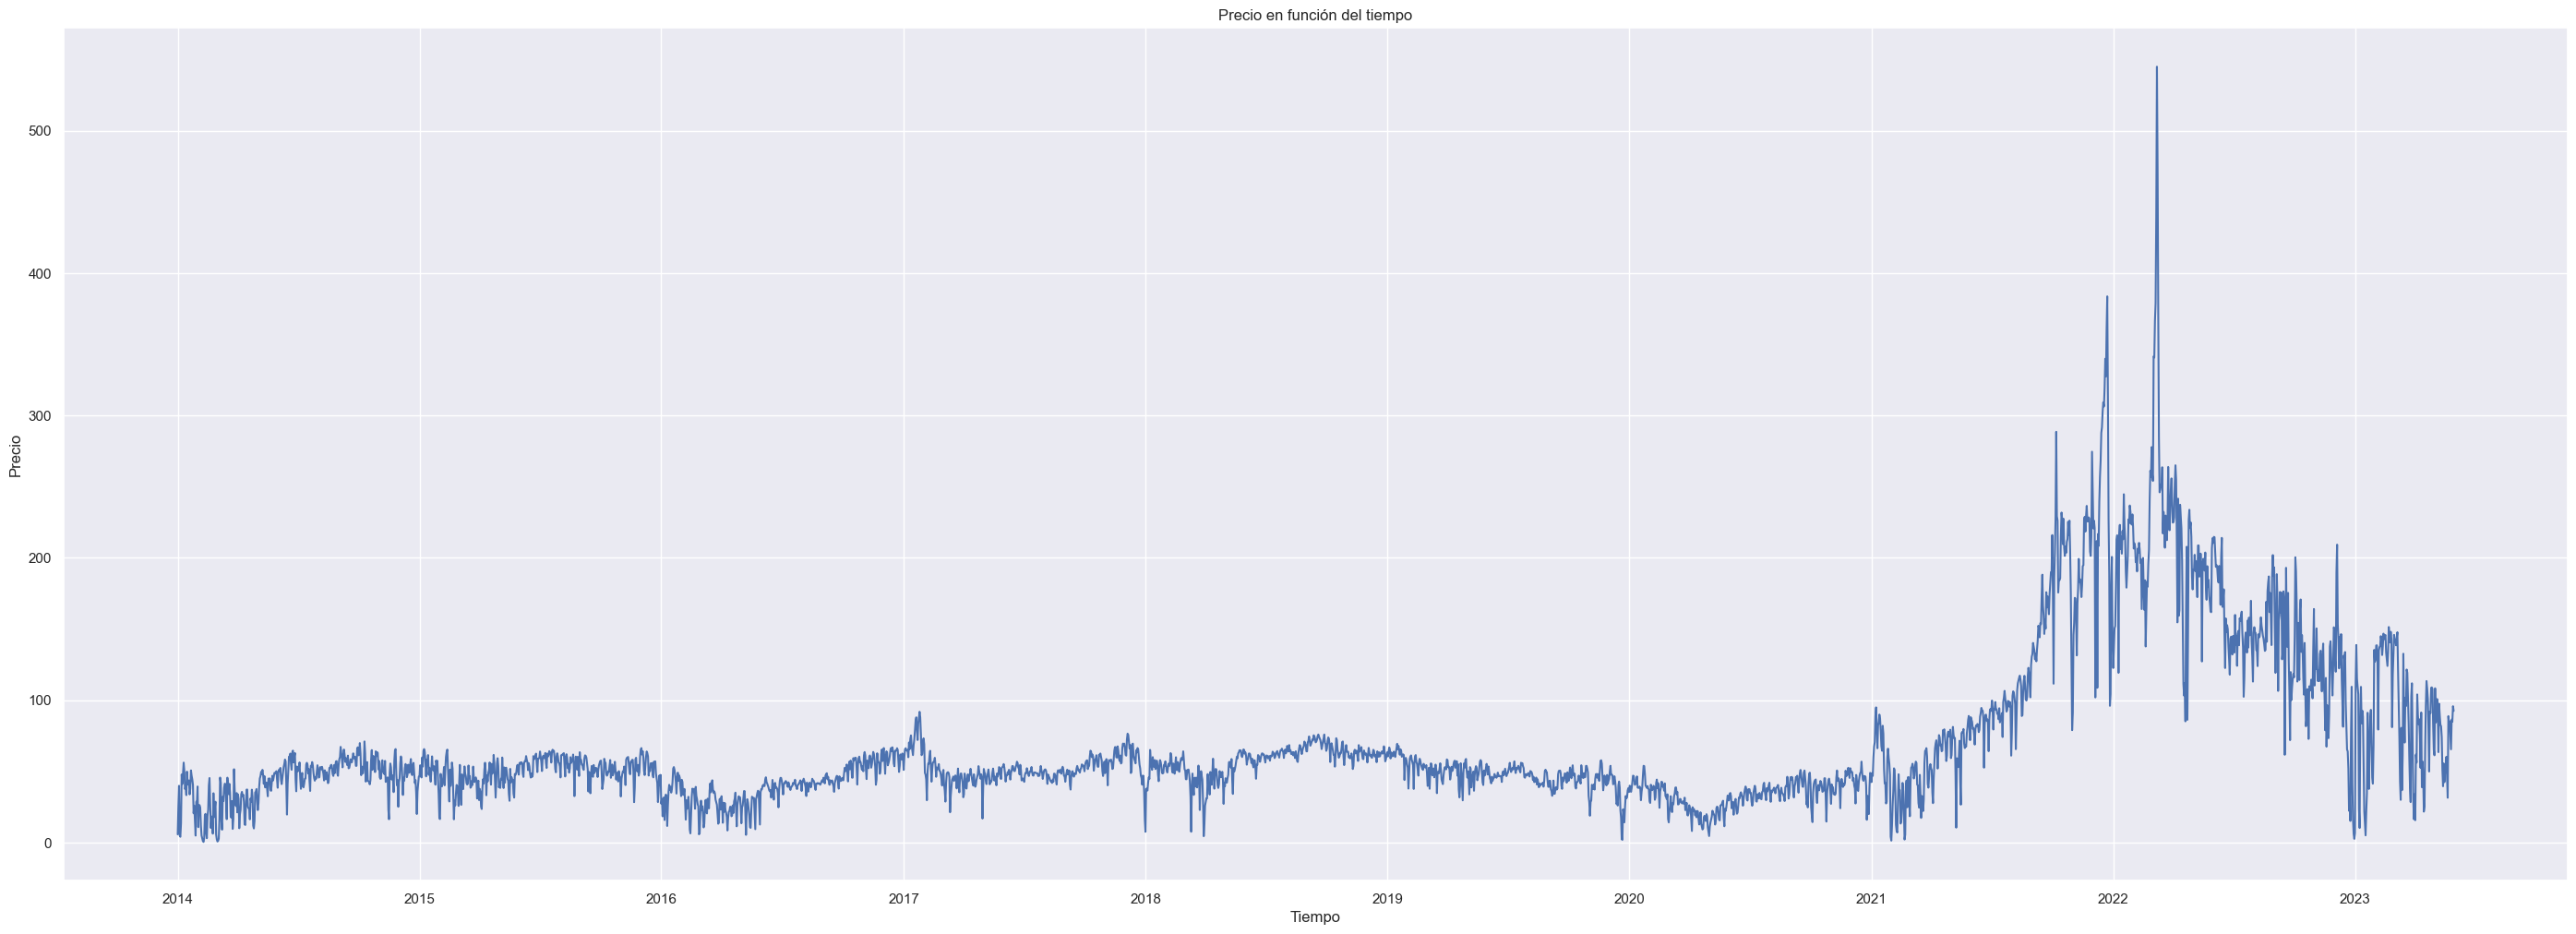

In [68]:
sns.set_style("darkgrid")
fig = plt.figure(figsize=(35,12))

sns.lineplot(x=df['datetime'], y=df['value'])

plt.title('Precio en función del tiempo')
plt.xlabel('Tiempo')
plt.ylabel('Precio')



Calculo de la media y desviación estándar móvil utilizando los últimos 4 valores, se emplea para resaltar las tendencias y variaciones a largo plazo

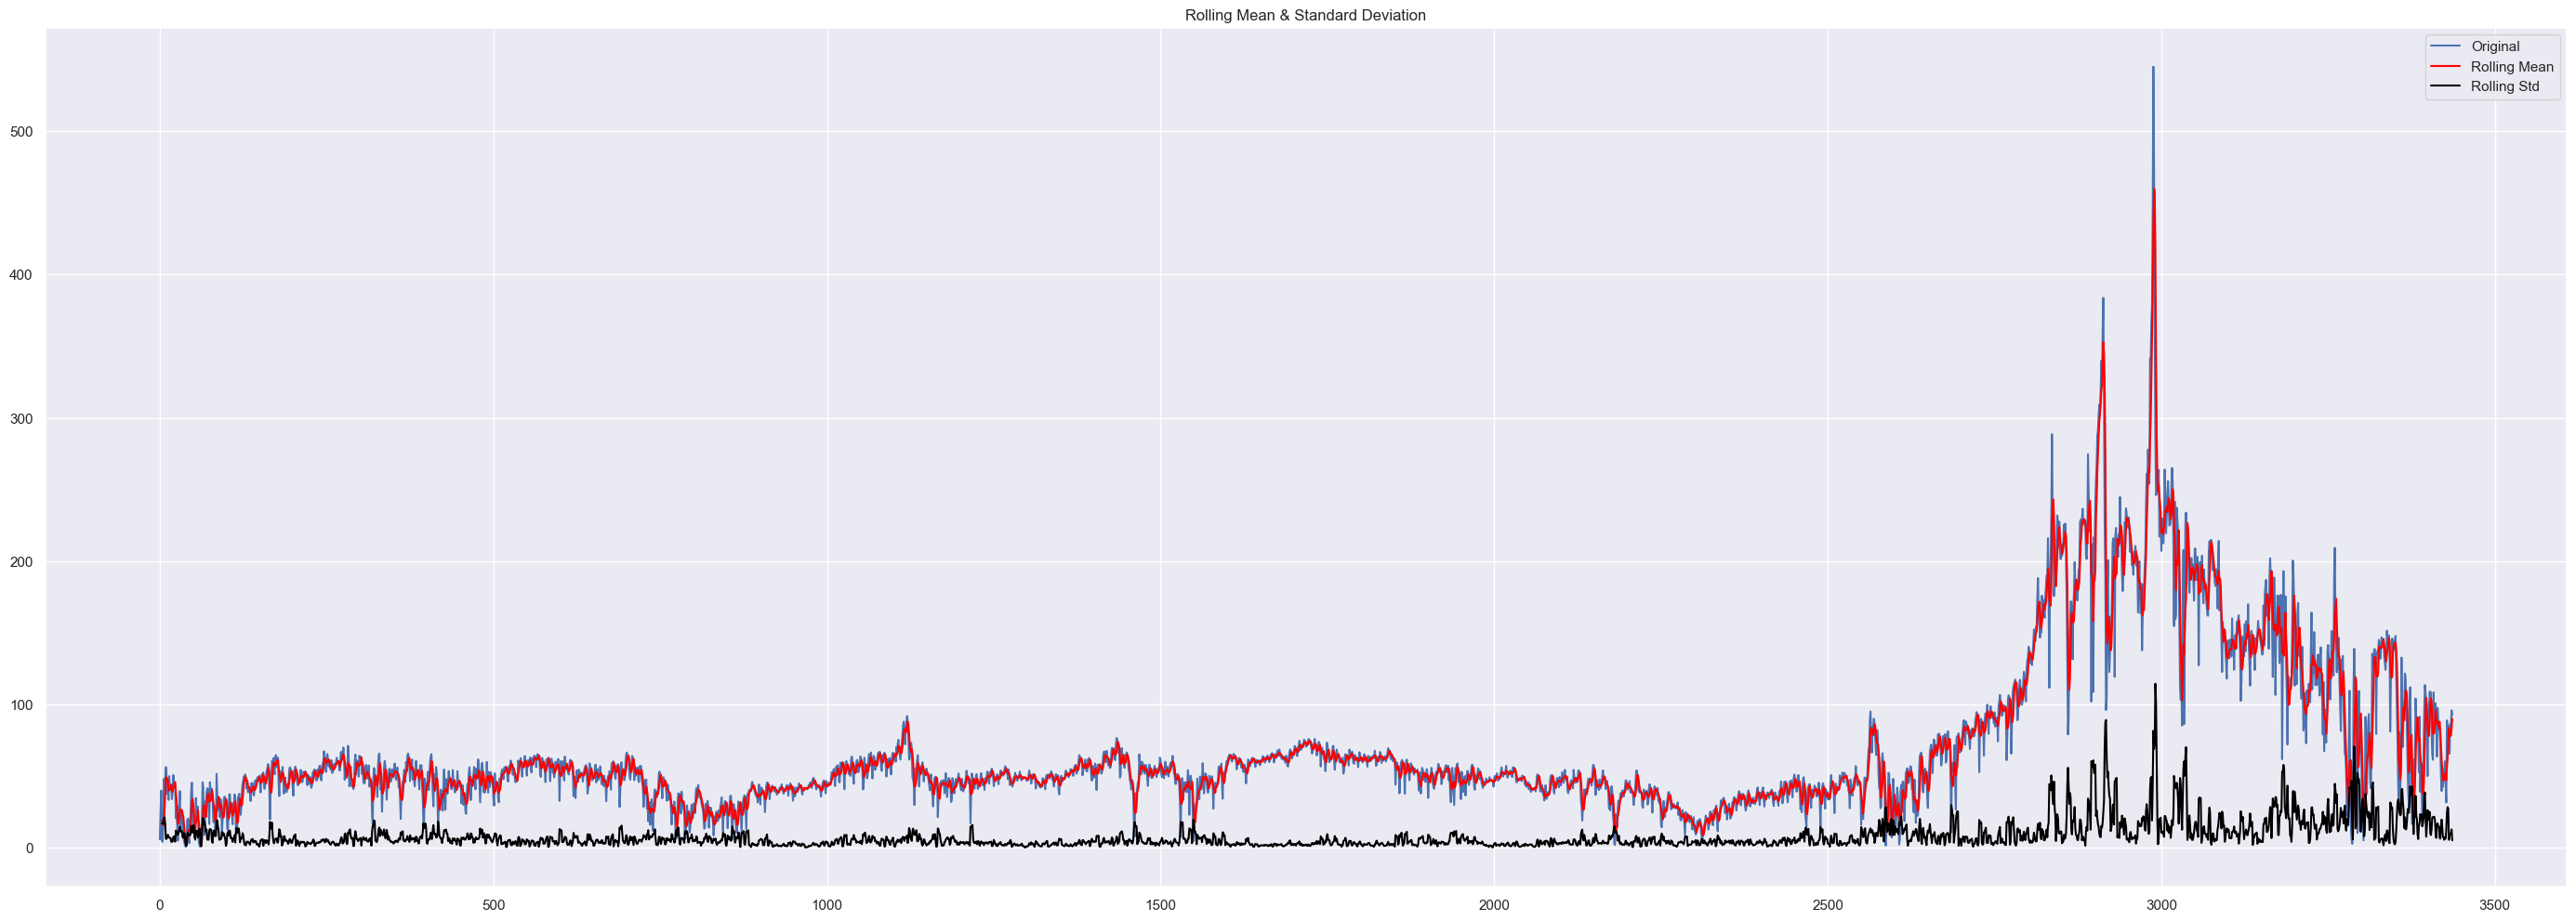

In [69]:

roll_mean = df['value'].rolling(window=4, center=False).mean()
roll_std = df['value'].rolling(window=4, center=False).std()
fig = plt.figure(figsize=(35,12))
plt.plot(df['value'], label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

### Precio medio de la electricidad por año para cada mes

No sé qué he hecho con el df pivot :( 

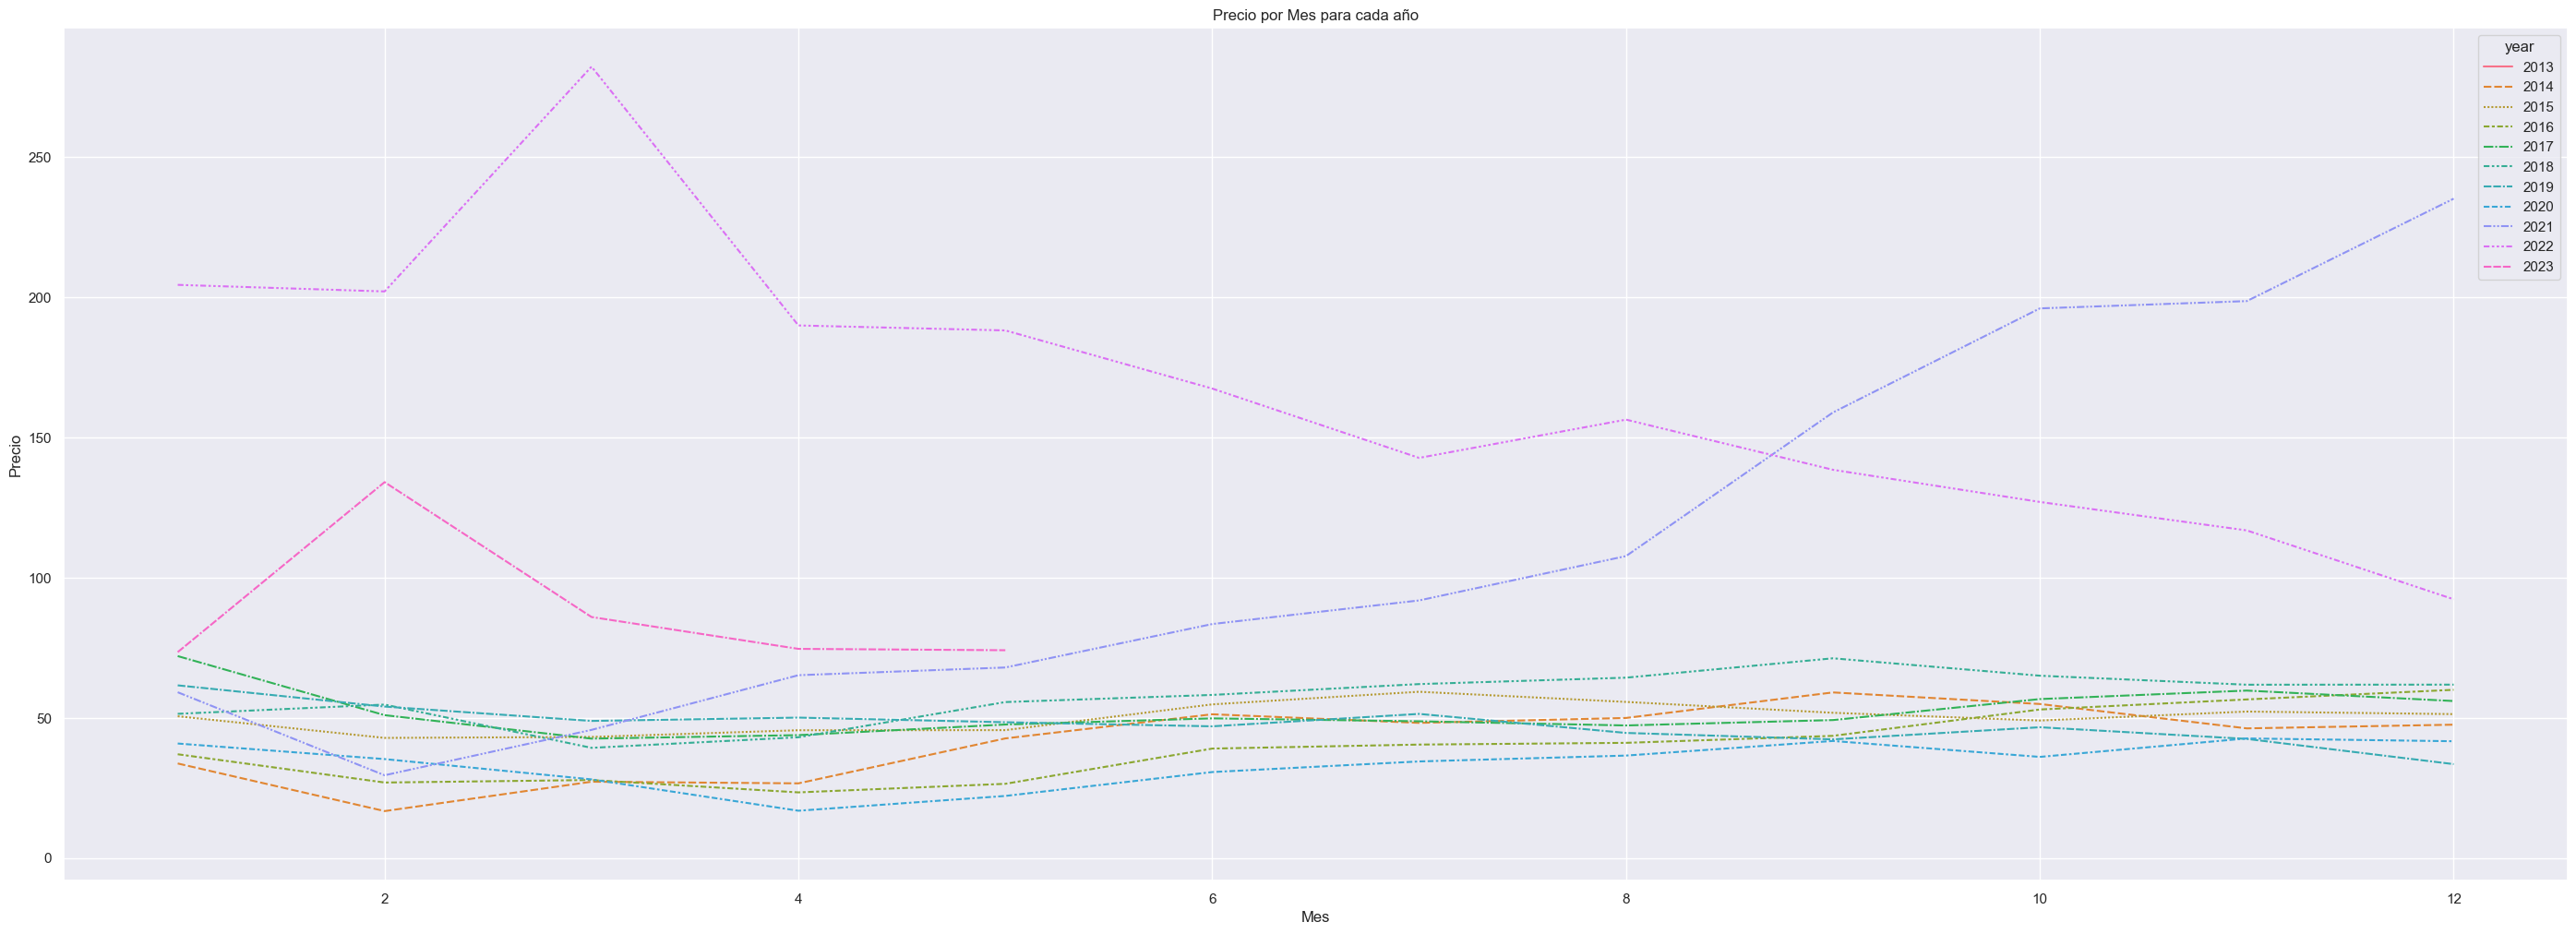

In [70]:
fig = plt.figure(figsize=(35,12))
sns.set_style("darkgrid")

# Crear la tabla pivotante utilizando pd.pivot_table()
df_pivot = pd.pivot_table(df, index='mes', columns='year', values='value')

# Crear el gráfico utilizando Seaborn
ax = sns.lineplot(data=df_pivot)

# Configurar el título y las etiquetas de los ejes
plt.title('Precio por Mes para cada año')
plt.xlabel('Mes')
plt.ylabel('Precio')

# Mostrar el gráfico
plt.show()

### Gas natural vs Precio eléctricidad

Importo csv del Gas Natural

In [75]:
gasn = pd.read_csv('clean_data/gasnatural.csv')
gasn

,Unnamed: 0,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.
0,0,2023-05-30,2.317,2.347,2.372,2.308,NaN,"-1,36%"
1,1,2023-05-29,2.349,2.434,2.447,2.338,NaN,"-3,53%"
2,2,2023-05-28,2.435,2.418,2.441,2.417,NaN,"11,65%"
3,3,2023-05-26,2.181,2.292,2.298,2.143,"2,17K","-5,46%"
4,4,2023-05-25,2.307,2.413,2.441,2.258,"48,66K","-3,79%"
...,...,...,...,...,...,...,...,...
2474,2474,2014-01-07,4.299,4.308,4.430,4.262,"159,42K","-0,16%"
2475,2475,2014-01-06,4.306,4.313,4.379,4.266,"91,96K","0,05%"
2476,2476,2014-01-03,4.304,4.298,4.390,4.206,"141,97K","-0,39%"
2477,2477,2014-01-02,4.321,4.232,4.331,4.213,"98,00K","2,10%"


In [77]:
data1

,value,datetime,mes,dia,week,year,date,weekend
2923,136.968333,2022-01-01 23:00:00+00:00,1,1,52,2022,2022-01-01,1
2924,150.498333,2022-01-02 23:00:00+00:00,1,2,52,2022,2022-01-02,1
2925,152.145417,2022-01-03 23:00:00+00:00,1,3,1,2022,2022-01-03,0
2926,180.200000,2022-01-04 23:00:00+00:00,1,4,1,2022,2022-01-04,0
2927,212.979167,2022-01-05 23:00:00+00:00,1,5,1,2022,2022-01-05,0
...,...,...,...,...,...,...,...,...
3432,65.545833,2023-05-25 22:00:00+00:00,5,25,21,2023,2023-05-25,0
3433,86.415833,2023-05-26 22:00:00+00:00,5,26,21,2023,2023-05-26,0
3434,84.942500,2023-05-27 22:00:00+00:00,5,27,21,2023,2023-05-27,1
3435,95.802083,2023-05-28 22:00:00+00:00,5,28,21,2023,2023-05-28,1


### Petroleo Brent

In [ ]:
brent = pd.read_csv('data_materias/brent.csv')

In [ ]:
brent.head()

,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.
0,30.05.2023,"73,71","77,04","77,59","73,32","461,39K","-4,36%"
1,29.05.2023,"77,07","77,39","77,75","76,15","31,55K","0,16%"
2,26.05.2023,"76,95","76,09","77,35","75,73","150,62K","0,90%"
3,25.05.2023,"76,26","78,22","78,50","75,10","237,72K","-2,68%"
4,24.05.2023,"78,36","77,70","78,66","77,03","285,99K","1,98%"


In [ ]:
brent['Fecha'] = pd.to_datetime(brent['Fecha'], format='%d.%m.%Y')

In [ ]:
for c in columnas_transf:
    brent = punto(brent,c)

NameError: name 'columnas_transf' is not defined

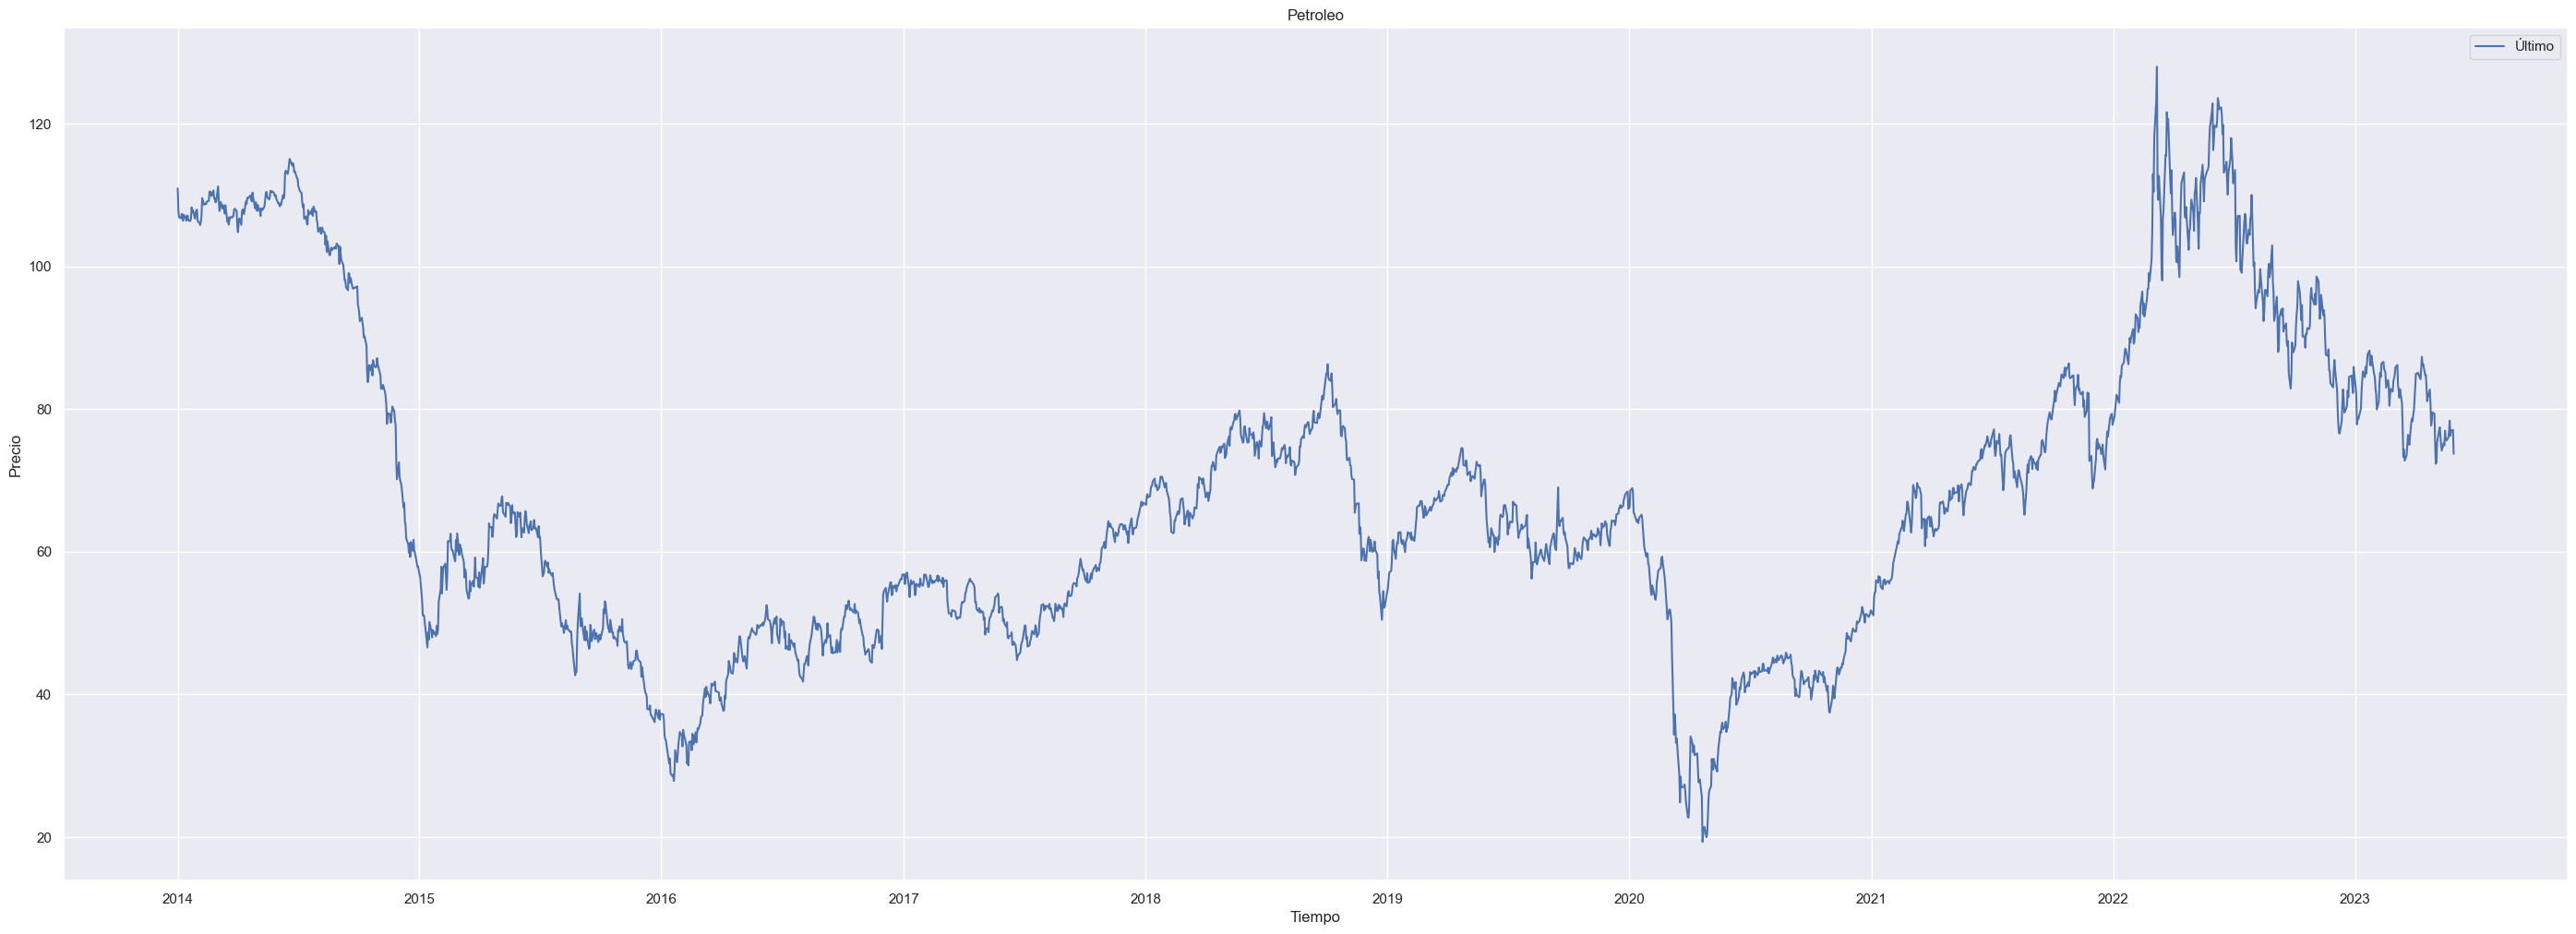

In [ ]:
sns.lineplot(x=brent.Fecha,y=brent['Último'], data=brent['Último'])

# Personalizar el gráfico
plt.title('Petroleo')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend(['Último'])

# Mostrar el gráfico
plt.show()

### Precio de las emisiones de CO2

In [ ]:
emisiones = pd.read_csv('data_materias/emisiones_co2.csv')

In [ ]:
emisiones.head(
    
)

,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.
0,30.05.2023,"80,38","83,05","83,34","80,36","24,55K","-3,16%"
1,29.05.2023,"83,00","83,01","84,46","82,67","4,74K","-0,16%"
2,26.05.2023,"83,13","82,75","83,37","81,94","14,76K","0,61%"
3,25.05.2023,"82,63","85,03","85,15","82,63","20,74K","-2,55%"
4,24.05.2023,"84,79","85,81","86,26","84,55","13,80K","-1,18%"


In [ ]:
emisiones.describe().T

,count,unique,top,freq
Fecha,2428,2428,30.05.2023,1
Último,2428,1574,"5,54",9
Apertura,2428,1563,"5,74",8
Máximo,2428,1555,"5,22",8
Mínimo,2428,1559,"5,81",10
Vol.,2413,850,"0,01K",142
% var.,2428,947,"0,00%",47


In [ ]:
emisiones['Fecha'] = pd.to_datetime(emisiones['Fecha'], format='%d.%m.%Y')

In [ ]:
for c in columnas_transf:
    emisiones = punto(emisiones,c)

Gráfico precio de emisiones CO2

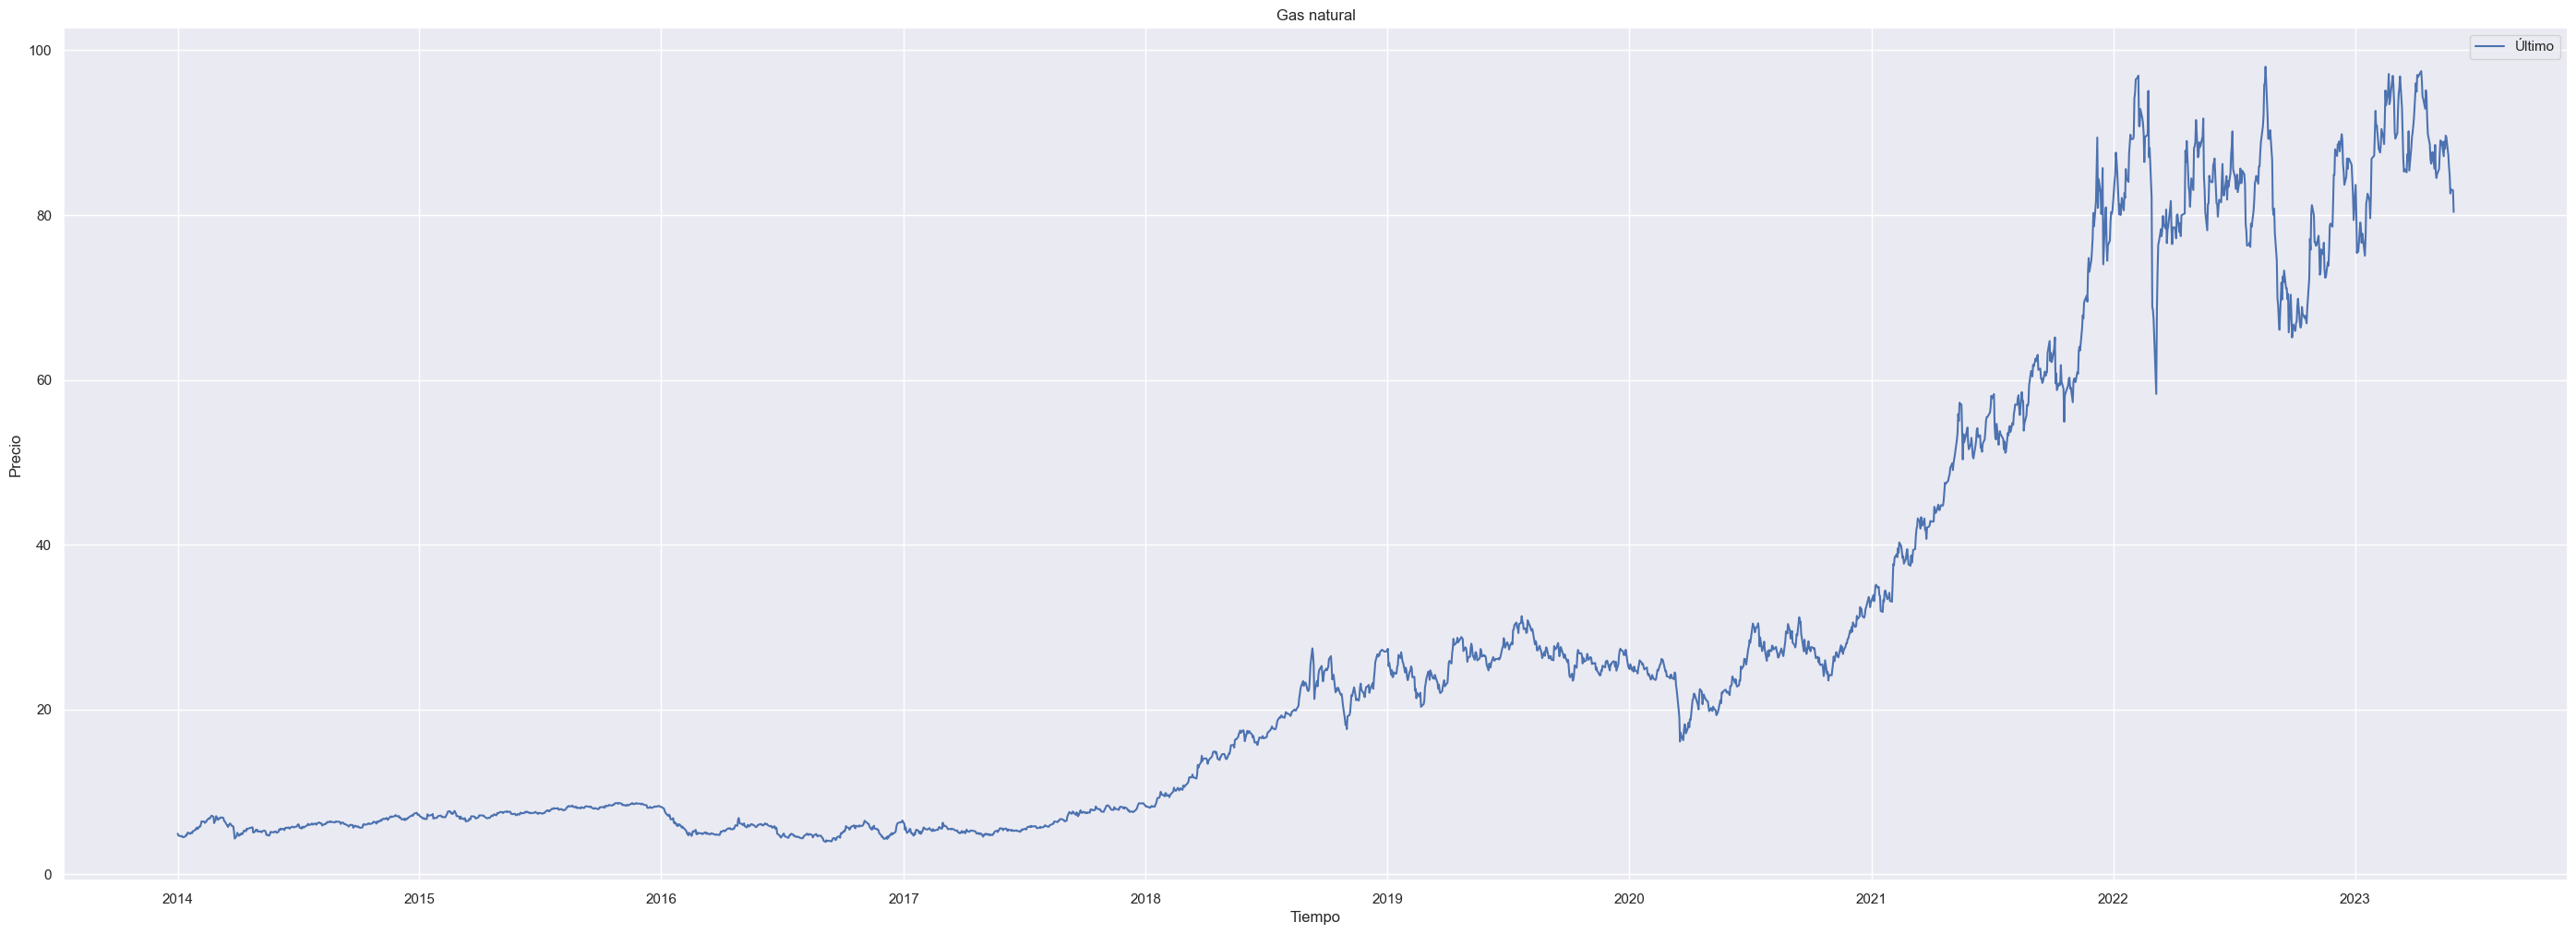

In [ ]:
sns.lineplot(x=emisiones.Fecha,y=emisiones['Último'], data=emisiones['Último'])

plt.title('Gas natural')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend(['Último'])

plt.show()

### Relación entre el petroleo Brent y el Gas Natural

Consideramos la relación entre estas dos variables, que tienen una relación lineal bastante clara: Se podría afirmar que una se podría expresar como función lineal de la otra.

Pero quien nos dice que esta relación no es espuria? Se podría dar que por el azar se comportasen de manera similar a lo largo de la historia pero que no sean una relación estacionaria. Aquí surge el termino de cointegración.

Dos series están cointegradas si se mueven conjuntamente a lo largo del tiempo y las diferencias entre ellas son estables. De aquí que la cointegración refleje la presencia de un equilibrio a largo plazo hacia el cual converge el sistema económico a lo largo del tiempo. Las diferencias (o término error) en la ecuación de cointegración se interpretan como el error de desequilibrio para cada punto particular de tiempo.

Serie estacionaria -> variable constanta a lo largo del tiempo

El test de Dickey-Fuller nos permite discriminar si una serie es estacionaria o no. No estacionrias de orden 1 quiere decir, que si tomamos las primeras diferencias de la series, conseguimos una serie estacionaria, con varianza contante en el tiempo.


### Añadiendo factor COVID

Dejar esto para cuando ya se haya recolectado todos los datos!!

Confinamiento COVID --> 15 mar 2020 – 21 jun 2020

In [ ]:

#df['Confinamiento'] = df['date'].apply(lambda x: 1 if datetime.date(2020, 3, 15) <= x <= datetime.date(2020, 6, 21) else 0)

### Añadiendo días festivos

Lo voy a hacer en un jupyter a parte q es movidote